In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import os
import random
from IPython.display import Image
from scipy.special import softmax
np.set_printoptions(suppress=True)

In [20]:
numpy_data_path = "../../pipe_one_aug/"
image_data_path = "../../Pokemon-data/"

model = torch.load("./saved-models/aug-freeze-customLR.pt")
model = model.cpu()
model.eval()

metadata = pd.read_csv('metadata/pokemon.csv')

filtered_metadata = metadata.loc[:,['name', 'type1']]
filtered_metadata.type1 = pd.Categorical(filtered_metadata.type1)
filtered_metadata['code'] = filtered_metadata.type1.cat.codes
filtered_metadata = filtered_metadata[["type1", "code"]].drop_duplicates()

In [21]:
LOGDIR = 'training-metrics'

In [22]:
def extract_type(idx):
    return filtered_metadata[filtered_metadata["code"] == idx]["type1"].values[0]

def make_prediction(name):
    numpy_files = os.listdir(numpy_data_path+name)
    image_files = os.listdir(image_data_path+name)
    file_idx = random.choice(list(enumerate(numpy_files)))[0]
    display(Image(filename=image_data_path+name+"/"+image_files[file_idx], width = 500, height = 300))
    image_array = np.load(numpy_data_path+name+"/"+numpy_files[file_idx])[:,:,:3]
    data = image_array.astype(np.float32)
    
    data = data.transpose()
    data = data[None,:,:,:]
    data = torch.tensor(data, dtype=torch.float)
    prediction = model(data).detach().numpy()[0]

    confident_idx = np.argmax(prediction)
    print(f"Model predicted: {extract_type(confident_idx)}")
    prediction = [(extract_type(idx), single_prediction) for idx, single_prediction in enumerate((softmax(prediction)*100))]
    prediction.sort(key=lambda x: x[1], reverse=True)
    prediction = [f"{single_prediction[0]}: {single_prediction[1]:.2f}%" for single_prediction in prediction]
    
    for idx, single_prediction in enumerate(prediction):
        print(single_prediction, end='\t')
        if (idx + 1) % 6 == 0:
            print("")

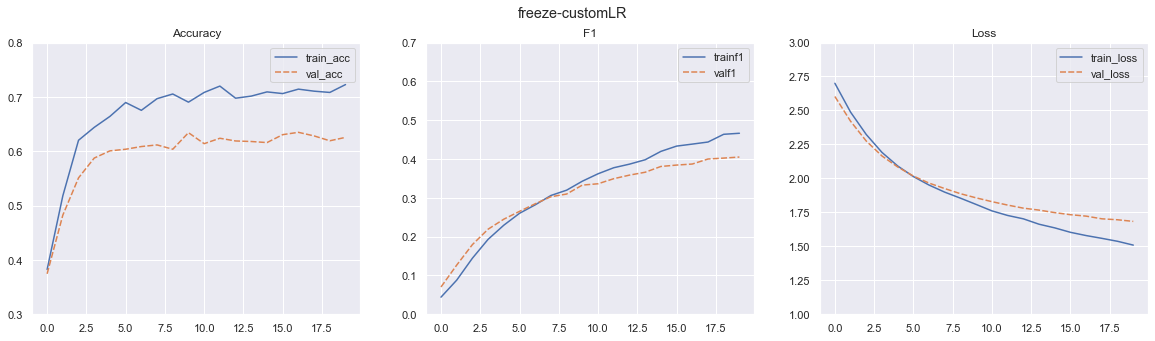

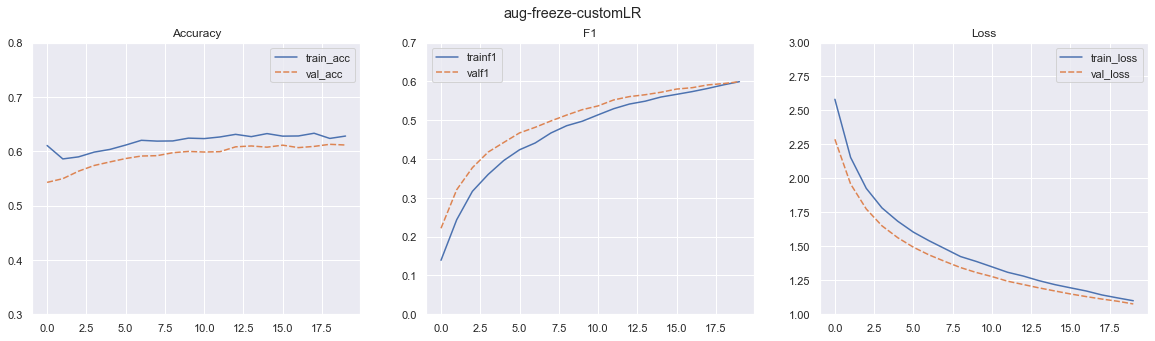

In [23]:
sns.set()
versions = ['freeze-customLR', 'aug-freeze-customLR']
for version in versions:

    metrics = pd.read_csv(f'{LOGDIR}/{version}.csv')

    figure, axes = plt.subplots(1, 3, sharex='all', figsize=(20,5))
    figure.suptitle(version)
    axes[0].set_title('Accuracy')
    axes[1].set_title('F1')
    axes[2].set_title('Loss')

    sns.lineplot(data=metrics[['train_acc', 'val_acc']], ax=axes[0])
    sns.lineplot(data=metrics[['trainf1', 'valf1']], ax=axes[1])
    sns.lineplot(data=metrics[['train_loss', 'val_loss']], ax=axes[2])

    axes[0].set_ylim(0.3, 0.8)
    axes[1].set_ylim(0, 0.7)
    axes[2].set_ylim(1, 3)

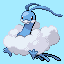

Model predicted: fairy
fairy: 30.27%	dragon: 28.82%	psychic: 8.64%	fighting: 5.65%	ground: 5.55%	water: 4.57%	
normal: 3.57%	steel: 3.21%	electric: 2.03%	grass: 1.79%	ice: 1.40%	bug: 1.24%	
rock: 0.86%	dark: 0.77%	fire: 0.51%	poison: 0.47%	flying: 0.43%	ghost: 0.22%	


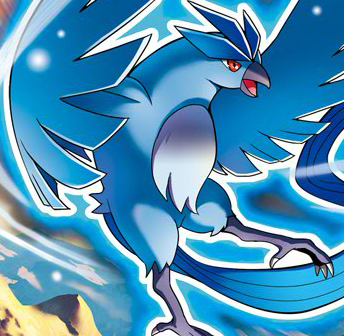

Model predicted: ice
ice: 67.18%	dragon: 12.62%	steel: 5.02%	psychic: 2.55%	water: 2.30%	normal: 1.89%	
fairy: 1.77%	fighting: 1.74%	electric: 1.57%	dark: 1.33%	fire: 0.47%	poison: 0.37%	
rock: 0.30%	bug: 0.22%	ground: 0.19%	flying: 0.19%	ghost: 0.17%	grass: 0.10%	


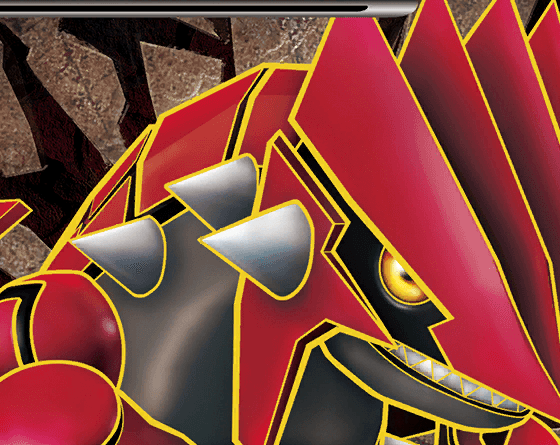

Model predicted: dragon
dragon: 17.33%	fairy: 15.16%	ice: 11.41%	normal: 10.54%	steel: 5.81%	electric: 5.54%	
water: 4.39%	dark: 4.35%	psychic: 3.60%	bug: 3.37%	ghost: 3.27%	fighting: 3.12%	
ground: 3.07%	rock: 2.83%	grass: 2.76%	fire: 2.51%	poison: 0.79%	flying: 0.14%	


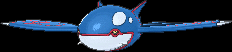

Model predicted: steel
steel: 39.46%	water: 17.55%	ice: 11.57%	dragon: 10.89%	electric: 6.50%	normal: 3.62%	
bug: 3.31%	poison: 2.68%	rock: 1.31%	grass: 1.03%	dark: 0.57%	fighting: 0.51%	
psychic: 0.49%	ground: 0.34%	fairy: 0.08%	fire: 0.05%	ghost: 0.03%	flying: 0.00%	


In [289]:
test_pokemon_list = ["Altaria","Articuno","Groudon", "Kyogre"]
for pokemon in test_pokemon_list:
    make_prediction(pokemon)